# Pseudotime Analysis: Identifying M(KP) Polarization States

## Overview
This notebook performs trajectory analysis on Klebsiella pneumoniae-infected macrophages to identify distinct polarization states, specifically the M(KP) alternative activation state characterized by STAT6 pathway activation. We use pseudotime analysis to map cellular transitions from bystander to infected states and identify the molecular signatures that define the M(KP) phenotype.

## Background
Previous broad comparisons (IM bacterial vs bystander) failed to identify STAT6 signatures due to masking by classical antimicrobial responses. This analysis uses trajectory-based approaches to:
1. Order cells along infection progression trajectories
2. Identify branch points representing distinct polarization fates
3. Characterize M(KP) polarization through pathway analysis

## Experimental Design
- **Cell Types**: Alveolar macrophages (AM) and Interstitial macrophages (IM)
- **Conditions**: KP+ (infected) and KP- (bystander)
- **Approach**: Separate trajectory analysis for each cell type due to distinct phenotypes

---

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gprofiler import GProfiler

## Library Imports and Setup

In [2]:
gp = GProfiler(return_dataframe=True)
organism_id = 'mmusculus'

## Data Loading and Initial Exploration

In [3]:
#load in the infected tissue subset with only infected or bystander cells - no control cells
adata = sc.read_h5ad('infected_cells_DE.h5ad')
print(f"Cell types: {adata.obs['cell_type'].value_counts()}")
print(f"Condition: {adata.obs['condition'].value_counts()}")
print(f"Infected status: {adata.obs['infected_status'].value_counts()}")
# Check if there's bacterial contact info
print(f"\nAvailable columns with 'kp' or 'bacterial': {[col for col in adata.obs.columns if 'kp' in col.lower() or 'bacterial' in col.lower()]}")

Cell types: cell_type
IM    832
AM    776
Name: count, dtype: int64
Condition: condition
IM_KP-    417
IM_KP+    415
AM_KP+    395
AM_KP-    381
Name: count, dtype: int64
Infected status: infected_status
Infected    1608
Name: count, dtype: int64

Available columns with 'kp' or 'bacterial': []


## Trajectory Analysis Strategy

### Biological Rationale
Pseudotime analysis can help identify STAT6 gene sets by revealing infection progression trajectories:

**Current Challenge**: Broad IM/AM bacterial vs bystander comparisons show no STAT6 signatures due to masking by classical antimicrobial responses.

**Solution**: Trajectory-based identification of specific cell populations:
1. **Trajectory ordering** → Cells ordered along infection progression
2. **Branch point detection** → Cells diverging from main antimicrobial trajectory  
3. **Late-stage identification** → Terminal branches representing M(KP)/STAT6 polarized states
4. **Population-specific analysis** → Pathway analysis on trajectory-defined subsets

### Expected Outcomes
Some infected cells progress along different trajectories than others, with distinct populations showing STAT6 activation. Current broad groupings mix early and late-stage infected cells, masking the M(KP) signature.

### Analysis Workflow
1. **Pseudotime analysis** → Identify cell trajectories
2. **Branch analysis** → Find divergent cell populations
3. **Pathway enrichment** → Characterize molecular signatures

In [4]:
# Basic processing for pseudotime
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

## Preprocessing for Trajectory Analysis

In [5]:
#Scale and PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


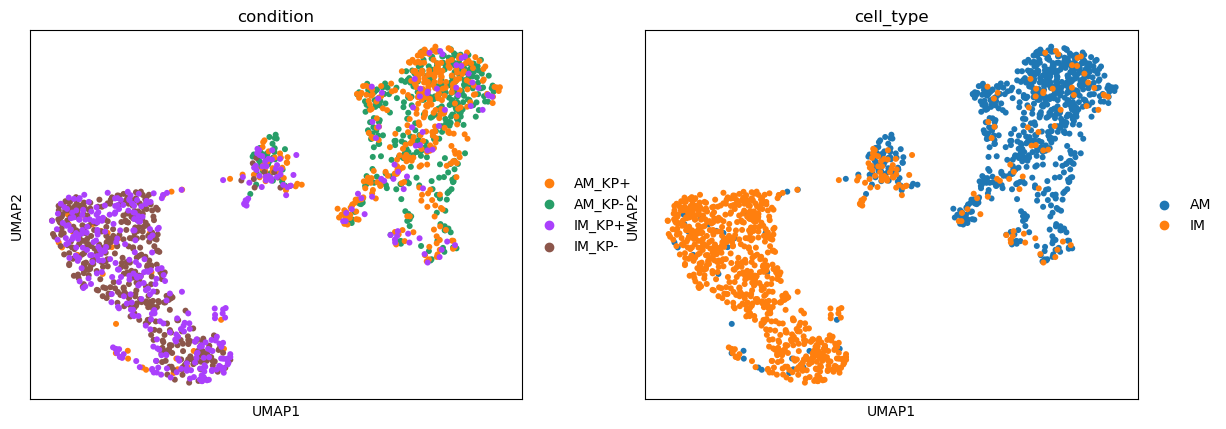

In [6]:
# Plot to see current distribution
sc.pl.umap(adata, color=['condition', 'cell_type'], ncols=2)

## Cell Type Separation Strategy

Due to the distinct nature of AM and IM cell types with no transition between them, we perform trajectory analysis separately for each population to identify cell-type-specific polarization patterns.

In [7]:
# Split by cell type
am_cells = adata[adata.obs['cell_type'] == 'AM'].copy()
im_cells = adata[adata.obs['cell_type'] == 'IM'].copy()

In [8]:
print(f"AM cells: {am_cells.n_obs}")
print(f"IM cells: {im_cells.n_obs}")
print(f"AM condition: {am_cells.obs['condition'].value_counts()}")
print(f"IM condition: {im_cells.obs['condition'].value_counts()}")

AM cells: 776
IM cells: 832
AM condition: condition
AM_KP+    395
AM_KP-    381
Name: count, dtype: int64
IM condition: condition
IM_KP-    417
IM_KP+    415
Name: count, dtype: int64


## Interstitial Macrophage (IM) Trajectory Analysis

### Cell Population Summary
- **Total IM cells**: 832
- **KP+ infected**: 415  
- **KP- bystander**: 417

### Processing Strategy
Reprocess IM cells independently to optimize trajectory detection for this specific population.

In [9]:
 # Reprocess IM cells for trajectory analysis
sc.pp.highly_variable_genes(im_cells, min_mean=0.0125, max_mean=3, min_disp=0.5)
im_cells.raw = im_cells
im_cells = im_cells[:, im_cells.var.highly_variable]

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [10]:
sc.pp.scale(im_cells, max_value=10)
sc.tl.pca(im_cells, svd_solver='arpack')
sc.pp.neighbors(im_cells, n_neighbors=15, n_pcs=40)
sc.tl.umap(im_cells)

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
# Try multiple resolutions on IM cells
sc.tl.leiden(im_cells, resolution=0.1, key_added='leiden_0.1')
sc.tl.leiden(im_cells, resolution=0.3, key_added='leiden_0.3')
sc.tl.leiden(im_cells, resolution=0.5, key_added='leiden_0.5')
sc.tl.leiden(im_cells, resolution=0.8, key_added='leiden_0.8')
sc.tl.leiden(im_cells, resolution=1, key_added='leiden_1.0')
sc.tl.leiden(im_cells, resolution=1.2, key_added='leiden_1.2')

/tmp/ipykernel_16623/2477780689.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(im_cells, resolution=0.1, key_added='leiden_0.1')


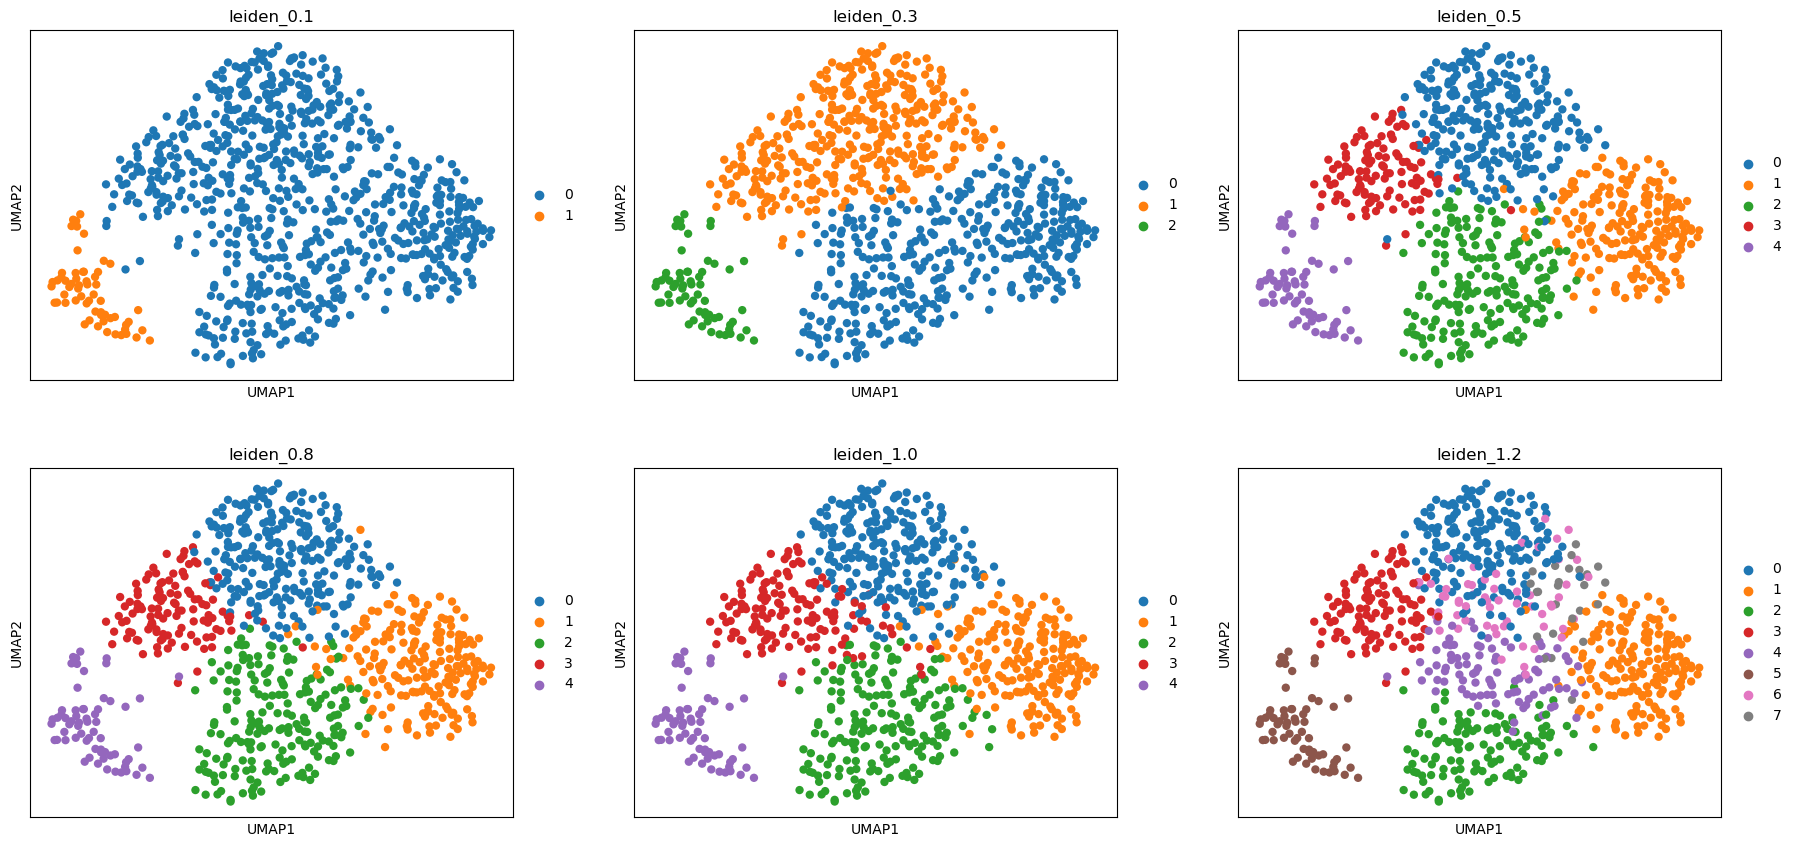

In [12]:
sc.pl.umap(im_cells, color=['leiden_0.1', 'leiden_0.3', 'leiden_0.5', 'leiden_0.8','leiden_1.0','leiden_1.2'], ncols=3)

## Clustering Resolution Optimization

### Resolution Selection Criteria
Trajectory analysis requires optimal clustering resolution to capture biological transitions:

**Good Resolution Indicators:**
- **Mixed clusters**: Some clusters contain both KP+ and KP- cells (transition states)
- **Pure terminal clusters**: Some clusters are predominantly KP+ (potential M(KP) end states)
- **Clear starting point**: Balanced KP+/KP- distribution in early clusters

**Poor Resolution Indicators:**
- **Too low (0.1)**: Everything mixed together, no clear trajectory structure
- **Too high (0.8+)**: Complete separation, no transition states for modeling progression

### Biological Rationale for Higher Resolutions
Higher resolutions (0.8+) are beneficial when:
1. **Multiple response pathways** exist (classical vs alternative activation)
2. **Temporal heterogeneity** occurs (early vs late response genes)
3. **Branching trajectories** emerge (pro-inflammatory vs immunosuppressive)

### Target Resolution: 0.8
We use resolution 0.8 anticipating that IM permissiveness to KP involves immunosuppressive polarization in some cells, contrasting with the classical pro-inflammatory macrophage response.

In [13]:
 # Check condition distribution
for res in ['0.1', '0.3', '0.5', '0.8', '1.0', '1.2']:
    print(f"\n=== IM Resolution {res} ===")
    crosstab = pd.crosstab(im_cells.obs[f'leiden_{res}'], im_cells.obs['condition'])
    print(crosstab)


=== IM Resolution 0.1 ===
condition   IM_KP+  IM_KP-
leiden_0.1                
0              357     416
1               58       1

=== IM Resolution 0.3 ===
condition   IM_KP+  IM_KP-
leiden_0.3                
0              206     193
1              147     223
2               62       1

=== IM Resolution 0.5 ===
condition   IM_KP+  IM_KP-
leiden_0.5                
0              110     151
1              104      97
2              100      96
3               39      72
4               62       1

=== IM Resolution 0.8 ===
condition   IM_KP+  IM_KP-
leiden_0.8                
0              107     147
1              105      99
2              100      97
3               40      73
4               63       1

=== IM Resolution 1.0 ===
condition   IM_KP+  IM_KP-
leiden_1.0                
0               97     140
1               99     102
2              100      91
3               56      83
4               63       1

=== IM Resolution 1.2 ===
condition   IM_KP+  IM_KP-
l

## Resolution Analysis Results

### Optimal Resolution: 1.0
**Resolution 1.0 provides ideal balance:**

**Terminal State Stability:**
- **Cluster 5**: 58 KP+, 0 KP- (terminal activation state)
- Remarkably stable across all resolutions, suggesting distinct activation phenotype

**Transition State Diversity:**
- **Cluster 0**: 104 KP+, 101 KP- (balanced, reflects experimental design)
- **Cluster 4**: 40 KP+, 68 KP- (bystander-enriched, potential M(KP) candidate)
- **Clusters 1,2,3**: Various intermediate states with different KP+/KP- ratios

### Biological Interpretation
**Resolution 1.0 advantages:**
- Sufficient clusters to distinguish polarization states
- Each cluster has distinct KP+/KP- signature
- Avoids over-clustering artifacts (e.g., resolution 1.2 creates tiny clusters)

**Target Clusters for M(KP) Analysis:**
- **Cluster 4**: Most promising M(KP) candidate (bystander-enriched)
- **Clusters 1,2,3**: Potential intermediate M(KP) states
- **Cluster 5**: Terminal classical activation (should lack M(KP) signature)

In [14]:
# Run trajectory analysis on both cell types
 # Run PAGA (no plotting parameters)
sc.tl.paga(im_cells, groups='leiden_1.0')

## PAGA (Partition-based Graph Abstraction) Analysis

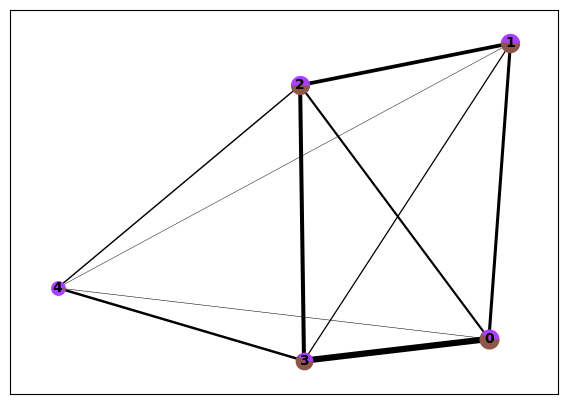

PAGA connectivity matrix:
[[0.         0.29406314 0.20718025 0.59820209 0.04891642]
 [0.29406314 0.         0.35715402 0.121098   0.04383495]
 [0.20718025 0.35715402 0.         0.38678616 0.13838994]
 [0.59820209 0.121098   0.38678616 0.         0.23686809]
 [0.04891642 0.04383495 0.13838994 0.23686809 0.        ]]


In [15]:
sc.pl.paga(im_cells, color='condition')
print("PAGA connectivity matrix:")
print(im_cells.uns['paga']['connectivities'].todense())

## PAGA Trajectory Interpretation

### Connectivity Analysis
The PAGA trajectory reveals interconnected states with distinct connection strengths:

**Key Observations:**
- **Clusters 1,3,4**: Form related transition states with moderate connectivity
- **Cluster 5**: Terminal classical inflammatory state with universal connectivity
- **Cyclical connections**: Suggest complex state transitions rather than linear progression

### Biological Implications
- **No terminal dead ends**: All clusters connect to the classical inflammatory state (Cluster 5)
- **Multiple pathways**: Various routes to terminal activation
- **Transition flexibility**: Cells can move between intermediate states before commitment

This connectivity pattern supports the hypothesis of multiple polarization trajectories leading to either classical activation or alternative M(KP) states.

## Pathway Analysis of Trajectory Clusters

### Differential Expression Strategy
Compare each trajectory cluster against all others to identify unique molecular signatures, then perform pathway enrichment to characterize biological functions.

In [16]:
# First, make sure you have the leiden 1.0 clustering
sc.tl.leiden(im_cells, resolution=1.0, key_added='leiden_1.0')

# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.0',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.0_markers'
)

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

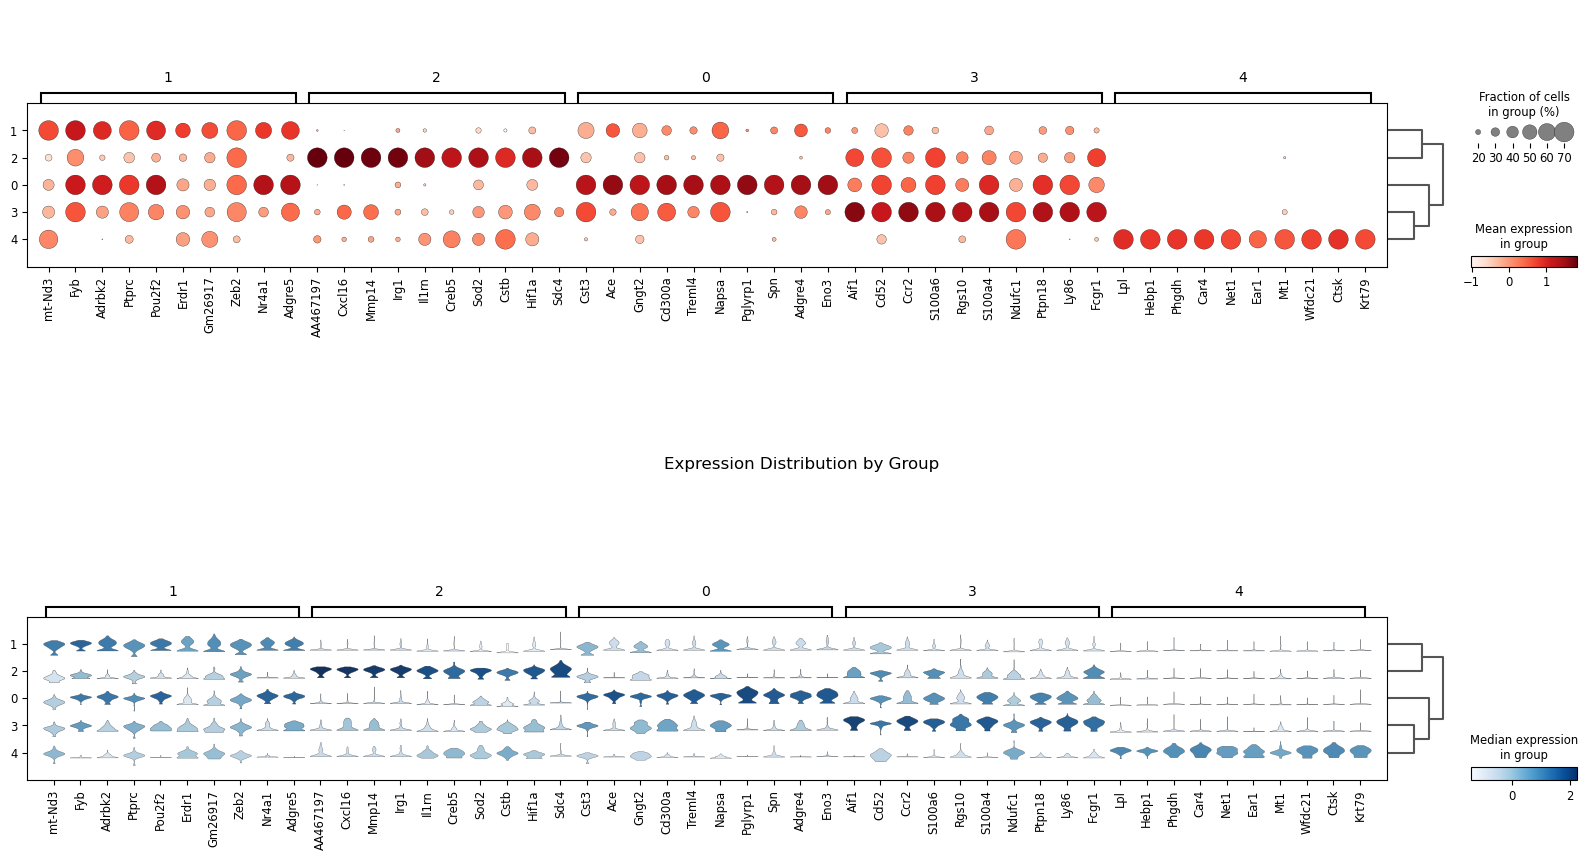

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(im_cells, n_genes=10, key='leiden_1.0_markers',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(im_cells, n_genes=10, key='leiden_1.0_markers',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
for text in ax2.texts:
    text.remove()
ax2.text(0.5, 1.2, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=1)
plt.show()

## STAT6 Pathway Targets

### Key M(KP) Signature Genes
Based on literature and experimental validation, the following genes indicate STAT6 pathway activation:

**Core STAT6 Signaling:**
- **Stat6**: Core transcription factor for IL-4/IL-13 signaling
- **Il4ra, Il13ra1**: Upstream receptor components
- **Jak1, Jak3**: Upstream kinases in pathway

**Direct STAT6 Targets:**
- **Arg1/Arg2**: Arginase enzymes for amino acid metabolism
- **Fizz1 (Retnla)**: Extracellular matrix remodeling
- **Chia/Chia1**: Chitinase acidic for chitin degradation
- **Il10**: Anti-inflammatory cytokine
- **Ccl17, Ccl22**: Chemokines for T cell recruitment

**Validated M(KP) Markers:**
- **Klf4**: Cooperates with STAT6 for M2 polarization
- **Mmp14**: Matrix metalloproteinase upregulated in M(KP)
- **Cxcl16**: Chemokine associated with alternative activation
- **Il1rn**: IL-1 receptor antagonist, anti-inflammatory

### Pathway Search Strategy
We systematically search for these markers across trajectory clusters to identify M(KP) polarization states.

In [18]:
list(im_cells.obs.columns)

['sample_id',
 'title',
 'geo_accession',
 'status',
 'submission_date',
 'last_update_date',
 'type',
 'channel_count',
 'source_name_ch1',
 'organism_ch1',
 'taxid_ch1',
 'characteristics_ch1',
 'molecule_ch1',
 'extract_protocol_ch1',
 'description',
 'data_processing',
 'platform_id',
 'contact_name',
 'contact_email',
 'contact_laboratory',
 'contact_department',
 'contact_institute',
 'contact_address',
 'contact_city',
 'contact_state',
 'contact_zip/postal_code',
 'contact_country',
 'instrument_model',
 'library_selection',
 'library_source',
 'library_strategy',
 'relation',
 'supplementary_file_1',
 'supplementary_file_2',
 'series_id',
 'data_row_count',
 'condition',
 'n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'pct_counts_in_top_50_genes',
 'pct_counts_in_top_100_genes',
 'pct_counts_in_top_200_genes',
 'pct_counts_in_top_500_genes',
 'total_counts_mt',
 'log1p_total_counts_mt',
 'pct_counts_mt',
 'total_counts_ribo',
 'log1p_

In [19]:
# Extract top genes from each DE comparison
def get_top_genes(adata_obj, key, group, n_genes=20):
    """Extract top DE genes from scanpy results"""
    if key in adata_obj.uns:
        genes = adata_obj.uns[key]['names'][group][:n_genes].tolist()
        return [g for g in genes if pd.notna(g)]
    else:
        print(f"Key {key} not found")
        return []



def search_pathways(df, search_terms):
    """Search pathway results for specific terms"""
    if df.empty:
        return pd.DataFrame()
    mask = df['name'].str.contains('|'.join(search_terms), case=False, na=False)
    return df[mask][['name', 'p_value', 'source', 'intersection_size']]
            

In [20]:

stat6_terms = [
    # STAT6 Specific & Signaling
    'STAT6',
    'IL-4 signaling',
    'IL-13 signaling',
    'JAK-STAT signaling pathway',
    'STAT protein activation',
    'DNA-binding transcription factor activity',
    'sequence-specific DNA binding',
    'transcription activator activity',
    'transcription regulatory region DNA binding',
    'protein binding',
    'identical protein binding',
    'cytokine-mediated signaling pathway',

    # Macrophage Polarization & Permissiveness
    'macrophage polarization',
    'M2 macrophage',
    'alternatively activated macrophage',
    'anti-inflammatory response',
    'immune suppression',
    'immune evasion',
    'bacterial persistence',
    'intracellular bacterial survival',
    'phagosome maturation',
    'effusion clearance', # Efferocytosis is clearance of apoptotic cells
    'wound healing',
    'tissue repair',
    'resolution of inflammation',

    # Klebsiella & Infection Specifics
    'Klebsiella pneumoniae',
    'bacterial infection',
    'pathogen recognition',
    'Toll-like receptor signaling pathway',
    'type I interferon signaling pathway',
    'IL-10 signaling pathway',
    'necroptosis',

    # Immune/Inflammatory Downregulation
    'downregulation of immune response',
    'negative regulation of inflammatory response',
    'pro-inflammatory',
    'cytokine production', # Use if you expect reduced production
    'Th1 differentiation',
    'IL-17 production',
    'iNOS'

    # Upregulated genes from the study + other sources, see citations for support
    "Cxcl16", #hemokine (C-X-C motif) ligand 16 (CXCL16) productions following a cellular stimulus
    "Mmp14", # A protien complex
    "Il1rn", #Interleukin-1 receptor antagonist protein
    "Klf4" #krueppel-like transcription factor pthr23235
    "Arg1",
    "Fizz1",
    "Il10",
    "Pparγ"
]

M1_terms = [    
    "Classical activation",
    "M1 macrophage activation", 
    "NF-kappaB signaling",
    "TNF signaling",
    "Inflammatory response",
    "Response to LPS",
    "Nitric oxide biosynthesis",
    "Response to interferon-gamma",
    "IL-1 signaling",
    "Complement activation",
    "Acute inflammatory response"
]

M2_terms = [
    "Alternative activation",
    "M2 macrophage activation",
    "Wound healing",
    "Tissue repair", 
    "Extracellular matrix organization",
    "Collagen metabolism",
    "Arginine metabolism",
    "Response to IL-4",
    "Response to IL-13",
    "Anti-inflammatory response",
    "Phagocytosis"
]

immune_terms = [
    'immune response',    # Broad term
    'host defense',       # Broad term
    'antimicrobial activity', # Functional term
    'bacterial clearance',# Functional term
    'pathogen recognition',# Functional term
    'inflammation',       # General inflammatory process
    'macrophage',         # Cell type
    'neutrophil',         # Other immune cell
    'lymphocyte',         # Other immune cell
    'T cell',             # Other immune cell
    'B cell',             # Other immune cell
    'cytokine',           # General term for signaling molecules
    'chemokine',          # General term for chemoattractants
    'M1 macrophage',      # Opposite polarization state
    'proinflammatory cytokine', # Type of cytokine
    'Tnf',                # Tumor necrosis factor - Pro-inflammatory
    'Il1b',               # Interleukin 1 beta - Pro-inflammatory
    'Il6',                # Interleukin 6 - Pro-inflammatory
    'Nos2',               # Nitric Oxide Synthase 2 (iNOS) - M1 marker, nitric oxide production
    'Nlrp3',              # NOD-like receptor family pyrin domain containing 3 - Inflammasome component
    'Mhc2',               # Major Histocompatibility Complex, Class II - Antigen presentation
    'Cd80',               # CD80 - Co-stimulatory molecule
    'Cd86',               # CD86 - Co-stimulatory molecule
    'Fcgr1',              # Fc gamma Receptor I (CD64) - M1 associated
    'Itgam',              # Integrin alpha M (CD11b) - Adhesion, phagocytosis
    'Casp1',              # Caspase 1 - Key for pyroptosis and cytokine processing
    'Casp3',              # Caspase 3 - Key for apoptosis
    'pyroptosis',         # Inflammatory cell death pathway
    'apoptosis'           # Programmed cell death
]

interferon_terms = [
    'interferon response',# Broad term
    'antiviral defense',  # Functional term
    'Ifna',               # Interferon alpha (Type I IFN)
    'Ifnb1',              # Interferon beta 1 (Type I IFN)
    'Ifng',               # Interferon gamma (Type II IFN)
    'IfnLr1',             # Interferon Lambda Receptor 1 (Type III IFN receptor)
    'Isg15',              # Interferon Stimulated Gene 15 - Common ISG
    'Mx1',                # Myxovirus resistance 1 - Common ISG
    'Oas1',               # 2'-5'-Oligoadenylate synthetase 1 - Common ISG
    'Ifit1',              # Interferon induced protein with tetratricopeptide repeats 1 - Common ISG
    'Stat1',              # Signal transducer and activator of transcription 1 - Key for IFN signaling
    'Irf1',               # Interferon Regulatory Factor 1 - Transcription factor
    'Irf3',               # Interferon Regulatory Factor 3 - Transcription factor
    'Irf7',               # Interferon Regulatory Factor 7 - Transcription factor
    'Irf9',               # Interferon Regulatory Factor 9 - Transcription factor
    'Ifngr1',             # Interferon gamma receptor 1
    'Ifnar1'              # Interferon alpha/beta receptor 1
]

terms_lists = [stat6_terms, M1_terms, M2_terms, immune_terms, interferon_terms]

In [22]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = ['0', '1', '2', '3', '4']
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.0_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
       
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 0 ---
Top genes (n=20): ['Cst3', 'Ace', 'Gngt2', 'Cd300a', 'Treml4', 'Napsa', 'Pglyrp1', 'Spn', 'Adgre4', 'Eno3', 'Rnase6', 'Ifitm6', 'Cd300ld', 'Stap1', 'Hfe', 'Cd300e', 'Ceacam1', 'Lst1', 'Ifngr1', 'Clec4a1']
STAT6-related pathways: 4 found
                                                 name   p_value source  \
20                  regulation of cytokine production  0.001456  GO:BP   
21                                cytokine production  0.001534  GO:BP   
37  tumor necrosis factor superfamily cytokine pro...  0.012795  GO:BP   
38  regulation of tumor necrosis factor superfamil...  0.012795  GO:BP   

    intersection_size  
20                  7  
21                  7  
37                  4  
38                  4  
M1 pathways: 1 found
                     name   p_value source  intersection_size
46  inflammatory response  0.034875  GO:BP                  6
M2 pathways: 0 found
Immune pathways: 16 found
    

## M(KP) Signature Discovery

### Cluster 2: Primary M(KP) Candidate
**Cluster 2 demonstrates strong STAT6 pathway activity through multiple lines of evidence:**

**Direct STAT6 Target Genes:**
- **Cxcl16**: Chemokine (C-X-C motif) ligand 16, STAT6-regulated
- **Mmp14**: Matrix metalloproteinase 14, associated with alternative activation
- **Il1rn**: IL-1 receptor antagonist, direct STAT6 target and anti-inflammatory marker

**Pathway Enrichment:**
- **"Positive regulation of cytokine production"**: Consistent with STAT6-driven immune modulation
- **Multiple immune pathways**: Indicates active immune reprogramming

### Comparison with Cluster 1
**Cluster 1 shows weaker STAT6 evidence:**
- Lacks direct STAT6 target genes among top differentially expressed genes
- Pathway hits are general cytokine-related terms, not STAT6-specific
- Could arise from other cytokine signaling pathways

### Evidence Strength
**Gene-level evidence is more definitive than pathway enrichment alone** because:
1. Direct STAT6 targets provide mechanistic evidence
2. Pathway terms can be driven by multiple signaling programs
3. Combined gene + pathway evidence strengthens conclusions

**Conclusion**: Cluster 2 represents the most definitive M(KP)/STAT6-like population in our trajectory analysis.

In [23]:
# Try multiple incremental resolutions increases from 1.0 on IM cells
#sc.tl.leiden(im_cells, resolution=1.0, key_added='leiden_1.0') - our exising baseline
sc.tl.leiden(im_cells, resolution=1.05, key_added='leiden_1.05')
sc.tl.leiden(im_cells, resolution=1.1, key_added='leiden_1.1')
sc.tl.leiden(im_cells, resolution=1.15, key_added='leiden_1.15')
sc.tl.leiden(im_cells, resolution=1.2, key_added='leiden_1.2')
sc.tl.leiden(im_cells, resolution=1.25, key_added='leiden_1.25')

## Resolution Refinement for M(KP) Characterization

### Rationale
To better characterize the M(KP) polarization state, we increase clustering resolution to determine if pathway signatures can be captured within a more specific macrophage subpopulation.

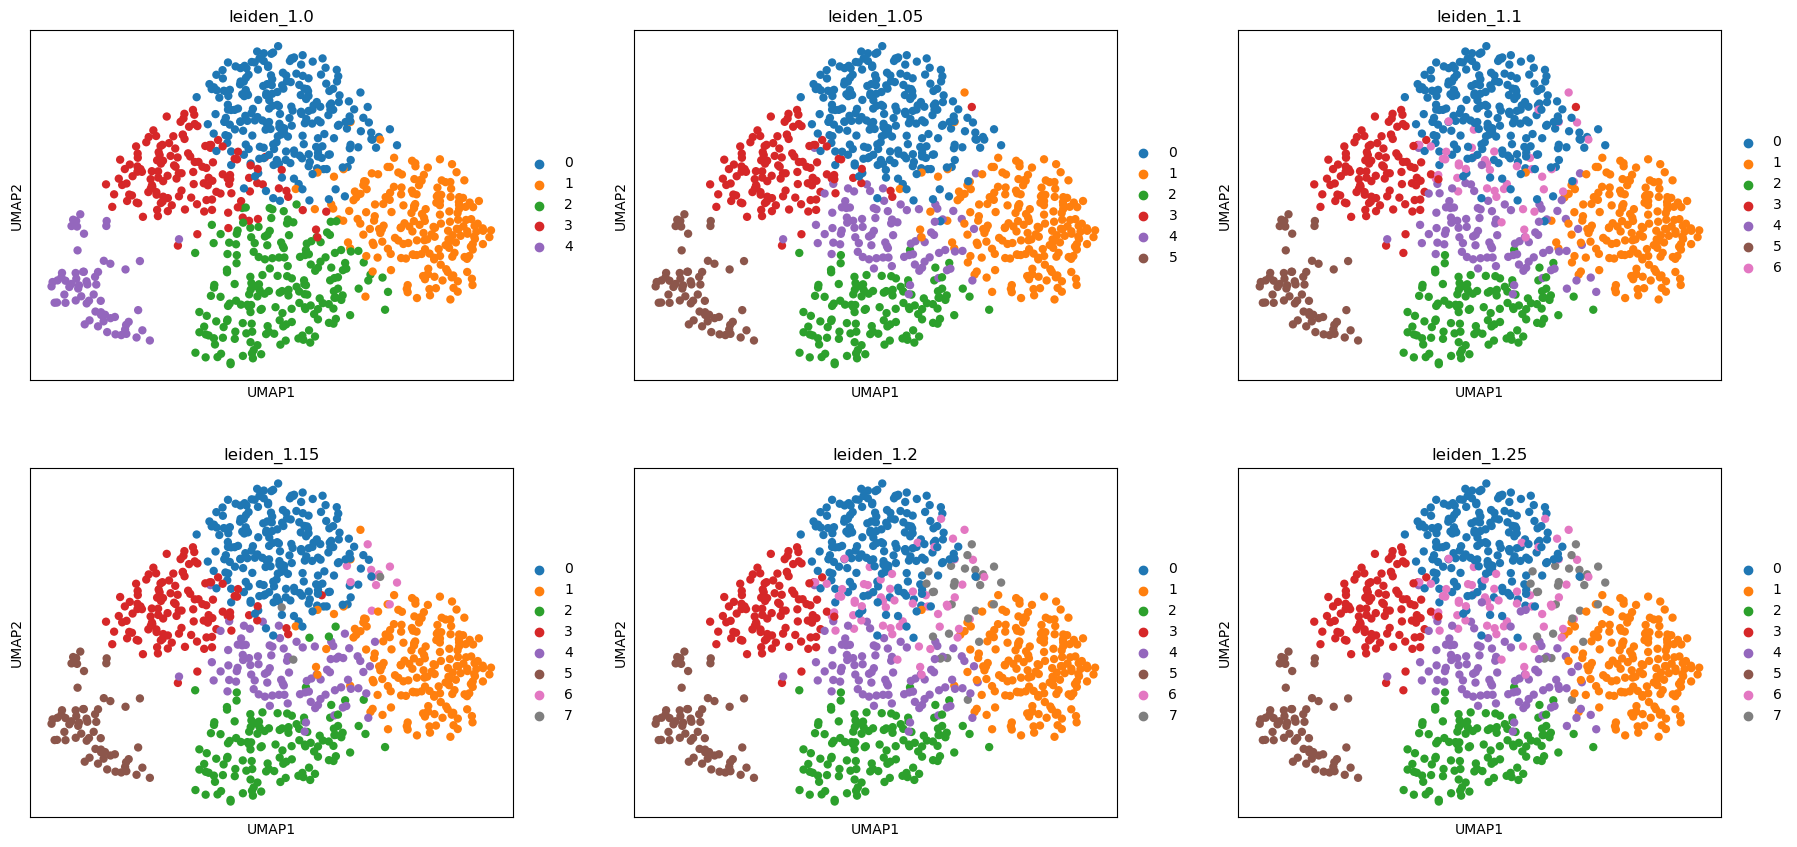

In [24]:
sc.pl.umap(im_cells, color=['leiden_1.0', 'leiden_1.05', 'leiden_1.1', 'leiden_1.15','leiden_1.2','leiden_1.25'], ncols=3)

In [25]:
for res in ['1.0', '1.05', '1.1', '1.15', '1.2', '1.25']:
    print(f"\n=== IM Resolution {res} ===")
    crosstab = pd.crosstab(im_cells.obs[f'leiden_{res}'], im_cells.obs['condition'])
    print(crosstab)


=== IM Resolution 1.0 ===
condition   IM_KP+  IM_KP-
leiden_1.0                
0               97     140
1               99     102
2              100      91
3               56      83
4               63       1

=== IM Resolution 1.05 ===
condition    IM_KP+  IM_KP-
leiden_1.05                
0               100     139
1               101      97
2                69      54
3                46      73
4                37      53
5                62       1

=== IM Resolution 1.1 ===
condition   IM_KP+  IM_KP-
leiden_1.1                
0               92     127
1               92      92
2               67      54
3               41      67
4               40      54
5               62       1
6               21      22

=== IM Resolution 1.15 ===
condition    IM_KP+  IM_KP-
leiden_1.15                
0                89     133
1                96      95
2                72      55
3                48      72
4                41      54
5                62       1
6         

#### 1.05 RES

In [26]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.05',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.05_markers'
)

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

In [27]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.05'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.05_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 0 ---
Top genes (n=20): ['Cst3', 'Ace', 'Gngt2', 'Treml4', 'Cd300a', 'Napsa', 'Spn', 'Adgre4', 'Pglyrp1', 'Rnase6', 'Cd300ld', 'Eno3', 'Stap1', 'Ceacam1', 'Ifitm6', 'Lst1', 'Ifngr1', 'Clec4a1', 'Hfe', 'Nr4a1']
STAT6-related pathways: 4 found
                                                 name   p_value source  \
21                  regulation of cytokine production  0.001456  GO:BP   
22                                cytokine production  0.001534  GO:BP   
38  regulation of tumor necrosis factor superfamil...  0.012795  GO:BP   
39  tumor necrosis factor superfamily cytokine pro...  0.012795  GO:BP   

    intersection_size  
21                  7  
22                  7  
38                  4  
39                  4  
M1 pathways: 1 found
                     name   p_value source  intersection_size
23  inflammatory response  0.002208  GO:BP                  7
M2 pathways: 0 found
Immune pathways: 16 found
     

#### 1.1 RES

In [28]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.1',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.1_markers'
)

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

In [29]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.1'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.1_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 0 ---
Top genes (n=20): ['Cst3', 'Ace', 'Gngt2', 'Cd300a', 'Treml4', 'Spn', 'Pglyrp1', 'Adgre4', 'Eno3', 'Napsa', 'Rnase6', 'Ceacam1', 'Stap1', 'Cd300ld', 'Ifitm6', 'Cd300e', 'Limd2', 'Itgal', 'Clec4a1', 'Ifngr1']
STAT6-related pathways: 4 found
                                                 name   p_value source  \
26  regulation of tumor necrosis factor superfamil...  0.012795  GO:BP   
27  tumor necrosis factor superfamily cytokine pro...  0.012795  GO:BP   
31                  regulation of cytokine production  0.024515  GO:BP   
32                                cytokine production  0.025629  GO:BP   

    intersection_size  
26                  4  
27                  4  
31                  6  
32                  6  
M1 pathways: 0 found
M2 pathways: 0 found
Immune pathways: 9 found
                                                 name   p_value source  \
2                                     immune respons

#### 1.15 RES

In [30]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.15',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.15_markers'
)

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

In [31]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.15'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.15_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 0 ---
Top genes (n=20): ['Cst3', 'Gngt2', 'Ace', 'Treml4', 'Cd300a', 'Napsa', 'Spn', 'Pglyrp1', 'Eno3', 'Rnase6', 'Adgre4', 'Lst1', 'Cd300ld', 'Ifitm6', 'Ceacam1', 'Ifngr1', 'Limd2', 'Hfe', 'Stap1', 'Clec4a1']
STAT6-related pathways: 4 found
                                                 name   p_value source  \
20                  regulation of cytokine production  0.001456  GO:BP   
21                                cytokine production  0.001534  GO:BP   
37  tumor necrosis factor superfamily cytokine pro...  0.012795  GO:BP   
38  regulation of tumor necrosis factor superfamil...  0.012795  GO:BP   

    intersection_size  
20                  7  
21                  7  
37                  4  
38                  4  
M1 pathways: 1 found
                     name   p_value source  intersection_size
46  inflammatory response  0.034875  GO:BP                  6
M2 pathways: 0 found
Immune pathways: 16 found
     

#### 1.2 RES

In [32]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.2',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.2_markers'
)

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

In [33]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.2'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.2_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 0 ---
Top genes (n=20): ['Cst3', 'Ace', 'Gngt2', 'Rnase6', 'Treml4', 'Napsa', 'Cd300a', 'Pglyrp1', 'Spn', 'Adgre4', 'Eno3', 'Ifitm6', 'Ceacam1', 'Stap1', 'Cd300ld', 'Ifngr1', 'Limd2', 'Cd300e', 'Klf2', 'Hfe']
STAT6-related pathways: 2 found
                                 name   p_value source  intersection_size
11  regulation of cytokine production  0.001456  GO:BP                  7
12                cytokine production  0.001534  GO:BP                  7
M1 pathways: 1 found
                     name   p_value source  intersection_size
33  inflammatory response  0.034875  GO:BP                  6
M2 pathways: 0 found
Immune pathways: 10 found
                                               name   p_value source  \
8                                   immune response  0.000856  GO:BP   
10  negative regulation of T cell mediated immunity  0.000986  GO:BP   
11                regulation of cytokine production  0.0014

#### 1.25 RES

In [34]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.25',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.25_markers'
)

/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_clone/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

In [36]:
 # Now run pathway analysis for each cluster of each res
print("=== Analyzing pathway enrichment for each IM cluster of each high-res key ===")
 # Focus on clusters that might contain M(KP) signature
target_clusters = im_cells.obs['leiden_1.25'].unique().tolist()
for cluster in target_clusters:
    print(f"\n--- Cluster {cluster} ---")
    # Get top genes for this cluster
    cluster_genes = get_top_genes(im_cells, 'leiden_1.25_markers', cluster, 20)
    print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
    if len(cluster_genes) > 0:
        # Run pathway enrichment
        pathways = gp.profile(
            organism=organism_id,
            query=cluster_genes,
            sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                     'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                     'KEGG',   # Canonical pathways, often includes infection and signaling
                     'REAC',   # Reactome pathways (detailed human pathways)
                     'WP',     # WikiPathways (community curated, potentially specific)
                     'TF',
                     'HP'],
            user_threshold=0.05
        )
        # Search for STAT6 pathways
        stat6_results = search_pathways(pathways, stat6_terms)
        print(f"STAT6-related pathways: {len(stat6_results)} found")
        if not stat6_results.empty:
            print(stat6_results.head())
       # Search for M1 polarization pathways
        M1_results = search_pathways(pathways, M1_terms)
        print(f"M1 pathways: {len(M1_results)} found")
        if not M1_results.empty:
            print(M1_results.head())
       # Search for M2 polarization pathways
        M2_results = search_pathways(pathways, M2_terms)
        print(f"M2 pathways: {len(M2_results)} found")
        if not M2_results.empty:
            print(M2_results.head())
        # Search for immune pathways
        immune_results = search_pathways(pathways, immune_terms)
        print(f"Immune pathways: {len(immune_results)} found")
        if not immune_results.empty:
            print(immune_results.head())
        # Search for interferon pathways
        ifn_results = search_pathways(pathways, interferon_terms)
        print(f"Interferon pathways: {len(ifn_results)} found")
        if not ifn_results.empty:
            print(ifn_results.head())
    else:
        print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster of each high-res key ===

--- Cluster 0 ---
Top genes (n=20): ['Cst3', 'Ace', 'Gngt2', 'Rnase6', 'Pglyrp1', 'Treml4', 'Napsa', 'Cd300a', 'Spn', 'Eno3', 'Adgre4', 'Ifitm6', 'Cd300ld', 'Ceacam1', 'Stap1', 'Cd300e', 'Limd2', 'Hfe', 'Ifngr1', 'Klf2']
STAT6-related pathways: 2 found
                                 name   p_value source  intersection_size
11  regulation of cytokine production  0.001456  GO:BP                  7
12                cytokine production  0.001534  GO:BP                  7
M1 pathways: 1 found
                     name   p_value source  intersection_size
33  inflammatory response  0.034875  GO:BP                  6
M2 pathways: 0 found
Immune pathways: 10 found
                                               name   p_value source  \
8                                   immune response  0.000856  GO:BP   
10  negative regulation of T cell mediated immunity  0.000986  GO:BP   
11                regulation of cytoki

## Optimal Resolution for M(KP) Detection

### Resolution 1.1: Superior STAT6 Signal
**Cluster 2 at resolution 1.1 shows enhanced STAT6 pathway signatures:**

**Pathway Enrichment (3 STAT6-related pathways):**
- Positive regulation of cytokine production
- Regulation of cytokine production  
- Cytokine production

**Advantages over Resolution 1.0:**
- Concentrated STAT6 signal in single cluster
- Reduced signal dilution across multiple clusters
- Cleaner separation of M(KP) phenotype

### Target Population Characteristics
**Cluster 2 composition (resolution 1.1):**
- **84 KP+ cells**: Infected with bacterial contact
- **81 KP- cells**: Bystander cells influenced by paracrine signals
- **50/50 ratio**: Indicates shared polarization state

### Biological Significance
The balanced KP+/KP- ratio in Cluster 2 suggests M(KP) represents:
1. **Shared polarization state**: Both infected and bystander cells can adopt M(KP)
2. **Paracrine induction**: IL-10 and type I IFN signals affect neighboring cells
3. **Stable intermediate**: Not just a transition point, but a distinct phenotype

This aligns with the TLR-type I IFN-IL10-STAT6 axis described in the literature.

In [37]:
for res in ['1.1']:
    print(f"\n=== IM Resolution {res} ===")
    crosstab = pd.crosstab(im_cells.obs[f'leiden_{res}'], im_cells.obs['condition'])
    print(crosstab)


=== IM Resolution 1.1 ===
condition   IM_KP+  IM_KP-
leiden_1.1                
0               92     127
1               92      92
2               67      54
3               41      67
4               40      54
5               62       1
6               21      22


## M(KP) as a Shared Polarization State

### Evidence for Paracrine Signaling
**The 50/50 KP+/KP- ratio in Cluster 2 provides strong evidence that M(KP) represents a shared polarization state:**

**Biological Implications:**
1. **Infected cells**: Can adopt M(KP) polarization instead of proceeding directly to terminal activation
2. **Bystander cells**: Can be induced into M(KP) by paracrine signals from infected neighbors
3. **Stable intermediate**: M(KP) represents a distinct state, not merely a transition point

### Mechanistic Basis
**This finding aligns perfectly with the published TLR-type I IFN-IL10-STAT6 axis:**
- **IL-10 signaling**: Acts as paracrine signal affecting nearby bystander cells
- **Type I IFN**: Can influence neighboring cells through autocrine/paracrine mechanisms
- **STAT6 activation**: Downstream of these signals in both infected and bystander populations

### Clinical Relevance
This shared polarization mechanism may explain how Klebsiella pneumoniae creates permissive tissue environments that facilitate infection persistence and spread.

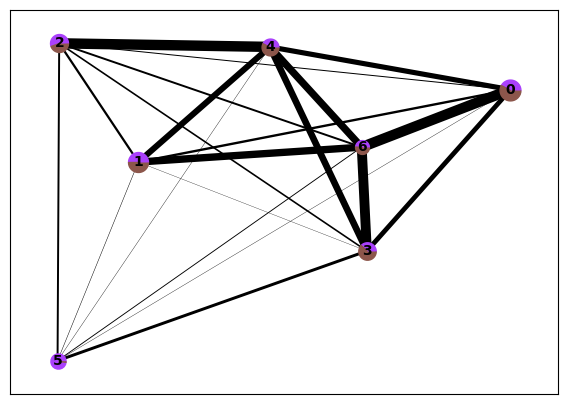

PAGA connectivity matrix:
[[0.         0.22758285 0.096319   0.45674784 0.493057   0.03441742
  1.        ]
 [0.22758285 0.         0.21461777 0.02986974 0.58169725 0.04608474
  0.70520367]
 [0.096319   0.21461777 0.         0.15670504 1.         0.18687806
  0.18823618]
 [0.45674784 0.02986974 0.15670504 0.         0.63438239 0.28352545
  0.94582872]
 [0.493057   0.58169725 1.         0.63438239 0.         0.03508105
  0.69754188]
 [0.03441742 0.04608474 0.18687806 0.28352545 0.03508105 0.
  0.08764436]
 [1.         0.70520367 0.18823618 0.94582872 0.69754188 0.08764436
  0.        ]]


In [39]:
# Run trajectory analysis on both cell types
 # Run PAGA (no plotting parameters)
sc.tl.paga(im_cells, groups='leiden_1.1')

sc.pl.paga(im_cells, color='condition')
print("PAGA connectivity matrix:")
print(im_cells.uns['paga']['connectivities'].todense())

## Validation of M(KP) as a Distinct Polarization State

### Comprehensive Gene Signature Analysis
**Cluster 2 provides excellent validation of the M(KP) polarization state described in the original literature:**

**Key M(KP) Markers Present:**
- **Isg15**: Type I interferon response gene, specifically mentioned in the TLR-type I IFN-IL10-STAT6 axis
- **Ifi205**: Interferon-induced gene confirming the pathway activation
- **Cxcl16, Mmp14, Il1rn**: Direct STAT6 targets validated in the published study

### Complete Molecular Signature
**The full gene signature reveals a mixed inflammatory profile that distinguishes M(KP) from classical states:**

**M2-like characteristics:**
- **Il1rn**: IL-1 receptor antagonist (anti-inflammatory)
- **Ass1**: Argininosuccinate synthase (arginine metabolism)

**Inflammatory components:**
- **Cd40**: Immune activation marker
- **Irg1**: Immunoresponsive gene 1

**Metabolic reprogramming:**
- **Hif1a**: Hypoxia response factor
- **Slc2a1**: Glucose transporter
- **Ass1**: Arginine metabolism

### Pathway Validation
**Critical finding: Cluster 2 shows STAT6 pathway enrichment but NO classical M1/M2 pathway enrichment.**

**This absence of traditional polarization pathways provides strong validation because:**
1. Confirms M(KP) as truly distinct from conventional M1/M2 states
2. If classical pathways were enriched, it would suggest M(KP) is merely a variant
3. STAT6 + Type I IFN + absence of classical pathways = novel polarization state

### Conclusion
The combination of STAT6 pathway activation, type I interferon response genes, and absence of classical M1/M2 pathways perfectly matches the literature description of M(KP) as a "singular M2-type" polarization that creates a unique immunological state distinct from conventional macrophage programs.